In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [5]:
def unique_stat(df: pd.DataFrame) -> pd.Series:
    uniq_stat = df.nunique()
    return uniq_stat[(uniq_stat == 1) | (uniq_stat == len(df))]


def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [6]:
income_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/income.csv")
print(income_df.shape)
income_df.head()

(32561, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
income_df = income_df.drop(columns=["education-num"])

In [8]:
unique_stat(income_df)

Series([], dtype: int64)

In [9]:
na_stat(income_df)

workclass         1836
occupation        1843
native-country     583
dtype: int64

In [10]:
income_df = income_df.dropna()
na_stat(income_df)

Series([], dtype: int64)

In [11]:
duplicates_stat(income_df)

age  workclass  education     marital-status      occupation         relationship   race                sex     capital-gain  capital-loss  hours-per-week  native-country  income >50K
33   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              15
35   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              14
51   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              13
39   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              13
37   Private    HS-grad       Married-civ-spouse  Craft-

In [12]:
income_df = income_df.drop_duplicates()
duplicates_stat(income_df)

Series([], dtype: int64)

In [13]:
count_categories(income_df)

workclass          7
education         16
marital-status     7
occupation        14
relationship       6
race               5
sex                2
native-country    41
dtype: int64

In [14]:
print(income_df.shape)
income_df.head()

(26904, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


0    20024
1     6880
Name: income >50K, dtype: int64


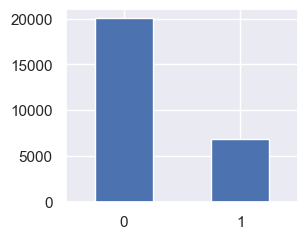

In [15]:
vc = income_df["income >50K"].value_counts()
print(vc)
income_df["income >50K"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [16]:
class IncomeDataset(Dataset):
    feature_encoder: OrdinalEncoder
    scaler: StandardScaler
    target_encoder: LabelEncoder
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(
            self,
            df: pd.DataFrame,
            feature_encoder: OrdinalEncoder = None,
            scaler: StandardScaler = None,
            target_encoder: LabelEncoder = None,
    ):
        if feature_encoder:
            self.feature_encoder = feature_encoder
            encode_features = self.feature_encoder.transform
        else:
            self.feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode_features = self.feature_encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        if target_encoder:
            self.target_encoder = target_encoder
            encode_targets = self.target_encoder.transform
        else:
            self.target_encoder = LabelEncoder()
            encode_targets = self.target_encoder.fit_transform

        target_col = "income >50K"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode_features(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.num_features = self.data.size(1)
        targets = encode_targets(targets)
        self.classes = [str(cls) for cls in self.target_encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [17]:
train_df, test_df = train_test_split(income_df, test_size=0.2, random_state=0)

train_dataset = IncomeDataset(train_df)
test_dataset = IncomeDataset(
    test_df,
    feature_encoder=train_dataset.feature_encoder,
    scaler=train_dataset.scaler,
    target_encoder=train_dataset.target_encoder,
)
len(train_dataset), len(test_dataset), train_dataset.num_features, train_dataset.classes

(21523, 5381, 12, ['0', '1'])

## Построение и обучение модели

In [18]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [19]:
class IncomeClassifier(nn.Module):

    def __init__(self, num_features: int, num_classes: int):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)

In [20]:
torch.manual_seed(0)

net = IncomeClassifier(
    num_features=train_dataset.num_features,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, drop_last=True)

net

IncomeClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [21]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=30,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 0.834909, accuracy: 0.5713
 Test Error: loss: 0.571025, accuracy: 0.6791

Epoch 2
--------------------------------
Train Error: loss: 0.579660, accuracy: 0.6932
 Test Error: loss: 0.531820, accuracy: 0.6926

Epoch 3
--------------------------------
Train Error: loss: 0.544992, accuracy: 0.7107
 Test Error: loss: 0.519224, accuracy: 0.6762

Epoch 4
--------------------------------
Train Error: loss: 0.521064, accuracy: 0.7208
 Test Error: loss: 0.489198, accuracy: 0.7098

Epoch 5
--------------------------------
Train Error: loss: 0.497844, accuracy: 0.7399
 Test Error: loss: 0.469434, accuracy: 0.7662

Epoch 6
--------------------------------
Train Error: loss: 0.484276, accuracy: 0.7493
 Test Error: loss: 0.456532, accuracy: 0.7393

Epoch 7
--------------------------------
Train Error: loss: 0.473217, accuracy: 0.7553
 Test Error: loss: 0.448424, accuracy: 0.7621

Epoch 8
--------------------------------
Train Error: loss: 0.

## Оценка и выводы

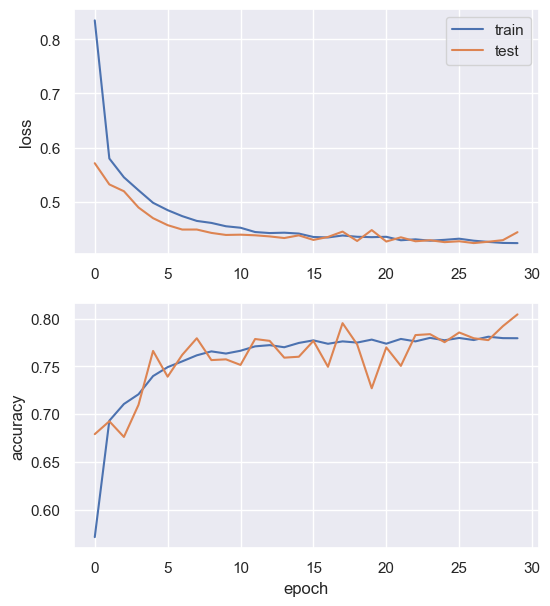

In [22]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [23]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

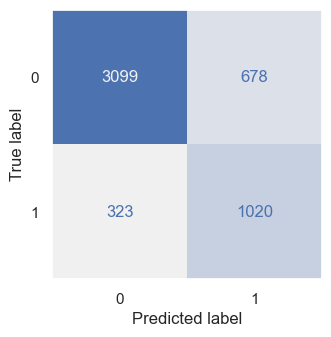

In [24]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [25]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      3777
           1       0.60      0.76      0.67      1343

    accuracy                           0.80      5120
   macro avg       0.75      0.79      0.77      5120
weighted avg       0.83      0.80      0.81      5120

